<a href="https://colab.research.google.com/github/ramzesssina/ML---labi/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **МЛ Практика 4: Задача классификации**

⏰ Домашнее задание
Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)
p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи
Для обоих задач побороться с дисбалансом классов следующими техниками:
oversampling (например, SMOTE)
или undersampling.
Для oversampling и undersampling используйте (https://imbalanced-learn.org/) Опишите полученный результат

Самый простой пример (желательно не использовать рандом)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle) для oversampling и undersampling (в задачи мультиклассовой классификации), оценить метрики и описать результат.

# **1: Загрузка библиотек и предобратка данных**

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/nba.csv')

df["max_min_on_fg"] = np.where(df['FG%'] >= 50, 1, 0)
df.max_min_on_fg = df.max_min_on_fg.astype('category')
df['Name'] = df['Name'].astype('category')

y = df['max_min_on_fg'] # выбираем целевую переменную (категориальную)
X = df.drop('max_min_on_fg', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('FG%', axis=1)
df.drop('FG%', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           1340 non-null   category
 1   GP             1340 non-null   int64   
 2   MIN            1340 non-null   float64 
 3   PTS            1340 non-null   float64 
 4   FGM            1340 non-null   float64 
 5   FGA            1340 non-null   float64 
 6   3P Made        1340 non-null   float64 
 7   3PA            1340 non-null   float64 
 8   3P%            1329 non-null   float64 
 9   FTM            1340 non-null   float64 
 10  FTA            1340 non-null   float64 
 11  FT%            1340 non-null   float64 
 12  OREB           1340 non-null   float64 
 13  DREB           1340 non-null   float64 
 14  REB            1340 non-null   float64 
 15  AST            1340 non-null   float64 
 16  STL            1340 non-null   float64 
 17  BLK            1340 non-null   fl

In [3]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

# **1.2 Проверка баланса**

In [4]:
y.value_counts()

,count
max_min_on_fg,
0,1123
1,217


# **1.3 Создание искусственного дисбаланса классов**

In [5]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['max_min_on_fg'] == 0]
minority = data[data['max_min_on_fg'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('max_min_on_fg', axis=1)
y_disbalanced = data_disbalanced['max_min_on_fg']


In [6]:
print(y_disbalanced.value_counts())

max_min_on_fg
0    1123
1     112
Name: count, dtype: int64


# **1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

non = X_train.dropna().index
X_train = X_train.loc[non]
y_train = y_train.loc[non]

non1 = X_test.dropna().index
X_test = X_test.loc[non1]
y_test = y_test.loc[non1]

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [8]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.962059620596206

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       336
           1       1.00      0.58      0.73        33

    accuracy                           0.96       369
   macro avg       0.98      0.79      0.86       369
weighted avg       0.96      0.96      0.96       369



In [9]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 350, 1: 19}

# **1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое**

In [10]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('max_min_on_fg', axis=1)
y_balanced = data_balanced['max_min_on_fg']

In [11]:
print(y_balanced.value_counts())

max_min_on_fg
0    217
1    217
Name: count, dtype: int64


In [12]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

non = X_train_bal.dropna().index
X_train_bal = X_train_bal.loc[non]
y_train_bal = y_train_bal.loc[non]

non1 = X_test_bal.dropna().index
X_test_bal = X_test_bal.loc[non1]
y_test_bal = y_test_bal.loc[non1]

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [13]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.9147286821705426

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92        67
           1       0.90      0.92      0.91        62

    accuracy                           0.91       129
   macro avg       0.91      0.91      0.91       129
weighted avg       0.91      0.91      0.91       129



In [14]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 66, 1: 63}

In [15]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [16]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

non = X_train_bal.dropna().index
X_train_bal = X_train_bal.loc[non]
y_train_bal = y_train_bal.loc[non]

non1 = X_test_bal.dropna().index
X_test_bal = X_test_bal.loc[non1]
y_test_bal = y_test_bal.loc[non1]

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [17]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.7829457364341085

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.80      0.73      0.76        62

    accuracy                           0.78       129
   macro avg       0.79      0.78      0.78       129
weighted avg       0.78      0.78      0.78       129



In [18]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 73, 1: 56}

# **2 Метрики качества классификаци**

# **2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)**

In [19]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

non = X_train_bal.dropna().index
X_train_bal = X_train_bal.loc[non]
y_train_bal = y_train_bal.loc[non]

non1 = X_test_bal.dropna().index
X_test_bal = X_test_bal.loc[non1]
y_test_bal = y_test_bal.loc[non1]


# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [21]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.80      0.73      0.76        62

    accuracy                           0.78       129
   macro avg       0.79      0.78      0.78       129
weighted avg       0.78      0.78      0.78       129



( Игроки набравшии меньше 50% очков за матч = 0, остальные = 1)

1) precision
    * 77% предсказанных игроков, набравших меньше 50% очков за матч, действительно игроков, набравших меньше 50% очков за матч.
    * 80% игроков, набравших больше 50% очков за матч, действительно игроков, набравших больше 50% очков за матч,

2) recall
    * Модель нашла 84% игроков, набравших меньше 50% очков за матч.
    * Модель нашла 73% игроков, набравших больше 50% очков за матч.

3)  f1-score
    * Игроков, набравших меньше 50% очков за матч (0.80), набравших больше 50% очков за матч (0.76) - баланс Precision и Recall для каждого класса.

4) accuracy
    * 78% всех предсказани правильны

In [22]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[56, 11],
       [17, 45]])

In [23]:
rounded_items

{'True Negatives (TN)': 56,
 'False Positives (FP)': 11,
 'False Negatives (FN)': 17,
 'True Positives (TP)': 45,
 'Accuracy': 0.78,
 'Precision': 0.8,
 'Recall': 0.73,
 'F1-score': 0.76,
 'ROC-AUC': 0.78}

# **3. Задача мультиклассовой классфикации**

In [24]:
y = pd.cut(df['FG%'], bins=[0, 50, 100], labels=[0, 1])

X = df.drop(['FG%', 'max_min_on_fg'], axis=1)

In [25]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [26]:
X

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,3P%,FTM,FTA,...,Name_Willie Cauley-Stein,Name_Willie Green,Name_Willie Reed,Name_Willie White,Name_Wilson Chandler,Name_Winston Bennett,Name_Winston Garland,Name_Xavier McDaniel,Name_Zach LaVine,Name_Zach Randolph
0,36,27.4,7.4,2.6,7.6,0.5,2.1,25.0,1.6,2.3,...,False,False,False,False,False,False,False,False,False,False
1,35,26.9,7.2,2.0,6.7,0.7,2.8,23.5,2.6,3.4,...,False,False,False,False,False,False,False,False,False,False
2,74,15.3,5.2,2.0,4.7,0.4,1.7,24.4,0.9,1.3,...,False,False,False,False,False,False,False,False,False,False
3,58,11.6,5.7,2.3,5.5,0.1,0.5,22.6,0.9,1.3,...,False,False,False,False,False,False,False,False,False,False
4,48,11.5,4.5,1.6,3.0,0.0,0.1,0.0,1.3,1.9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,80,15.8,4.3,1.6,3.6,0.0,0.2,14.3,1.2,1.5,...,False,False,False,False,False,False,False,False,False,False
1336,68,12.6,3.9,1.5,4.1,0.1,0.7,16.7,0.8,1.0,...,False,False,False,False,False,False,False,False,False,False
1337,43,12.1,5.4,2.2,3.9,0.0,0.0,0.0,1.0,1.6,...,False,False,False,False,False,False,False,False,False,False
1338,52,12.0,4.5,1.7,3.8,0.0,0.2,10.0,1.2,1.8,...,False,False,False,False,False,False,False,False,False,False


In [27]:
X.columns

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', '3P%', 'FTM', 'FTA',
       ...
       'Name_Willie Cauley-Stein', 'Name_Willie Green', 'Name_Willie Reed',
       'Name_Willie White', 'Name_Wilson Chandler', 'Name_Winston Bennett',
       'Name_Winston Garland', 'Name_Xavier McDaniel', 'Name_Zach LaVine',
       'Name_Zach Randolph'],
      dtype='object', length=1312)

# **3.1 Алгоритм дерева принятия решений**

Алгоритм дерева принятия решений (Decision Tree) — это один из методов машинного обучения, который используется для решения задач классификации и регрессии. Дерево решений представляет собой структуру, в которой каждый внутренний узел соответствует некоторому признаку, а каждая ветвь — определенному значению этого признака. Листовые узлы представляют собой классы или значения, которые необходимо предсказать.

Как работает дерево решений:
Корневой узел: Это первый узел в дереве, который соответствует самому информативному признаку. Признак выбирается на основе критериев, например по индексу Gini (различие по y, чем ближе к 1, тем разнороднее классы y в узле)

Разбиение данных: На каждом шаге дерево разбивает данные на подмножества в соответствии с выбранным признаком. Эти разбиения происходят рекурсивно, пока не будет достигнут некоторый критерий остановки (например, максимальная глубина дерева, минимальное количество данных в листе).

Листовые узлы: Листовые узлы содержат финальные предсказания. В случае задачи классификации это будет класс, а в случае регрессии — числовое значение.

Критерии остановки: Дерево останавливает разбиение, если достигается один из критериев остановки — например, если достигнута максимальная глубина дерева или в узле осталось меньше минимального числа данных для разбиения.

Преимущества:
Простота визуализации и интерпретации.
Может использоваться как для классификации, так и для регрессии.
Не требует предварительной нормализации данных.
Недостатки:
Может переобучаться (overfitting), если не ограничить глубину дерева.
Чувствительно к небольшим изменениям в данных.

In [28]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model =  DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [29]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       335
           1       0.54      0.43      0.48        67

    accuracy                           0.84       402
   macro avg       0.71      0.68      0.69       402
weighted avg       0.83      0.84      0.84       402



Про macro avg и weighted avg.:

Macro average (macro avg):

Этот показатель вычисляется как среднее арифметическое по каждому классу для всех метрик (precision, recall и f1-score). То есть сначала вычисляются precision, recall и f1-score для каждого класса, а затем они усредняются без учёта того, сколько примеров было в каждом классе. Этот показатель полезен, когда интересует равное внимание к каждому классу, независимо от его частоты в данных.
Проблема: Если классы несбалансированы (т.е. некоторые классы имеют намного больше примеров, чем другие), то этот показатель может быть искажен в сторону меньших классов.
Weighted average (weighted avg):

Этот показатель тоже вычисляется на основе метрик каждого класса (precision, recall и f1-score), но с учетом количества примеров (support) в каждом классе. То есть каждый класс вносит свой вклад в среднее значение пропорционально его количеству примеров в данных.
Преимущество: В отличие от macro avg, weighted avg корректнее отражает общую производительность модели на несбалансированных данных, так как учитывает частоту каждого класса.
Проще говоря:

Macro avg показывает усреднённое качество модели по всем классам, не обращая внимания на то, сколько примеров в каждом классе.
Weighted avg взвешивает качество по количеству примеров каждого класса, что делает его более устойчивым к несбалансированным классам.

In [30]:
accuracy_score(y_test_multi, y_pred_multi)

0.8432835820895522

In [31]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое

0.6791044776119403

# **Важность признаков**
Признаки, которые внесли наибольший вклад в модель

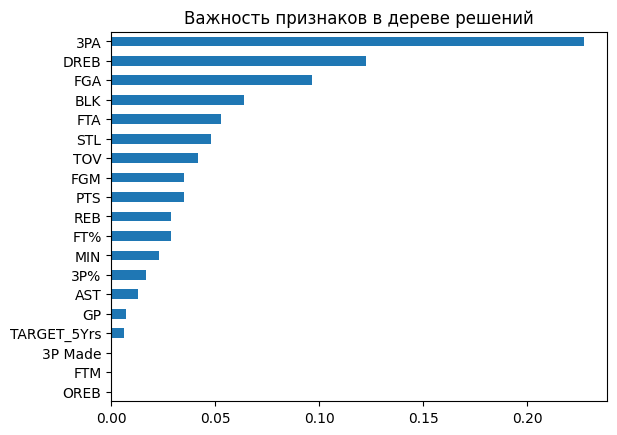

In [37]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)

columns_to_drop = feature_importances.index[feature_importances.index.str.startswith('Name_')]
feature_importances = feature_importances.drop(columns_to_drop)

feature_importances.sort_values().plot(kind='barh')

plt.title('Важность признаков в дереве решений')
plt.show()

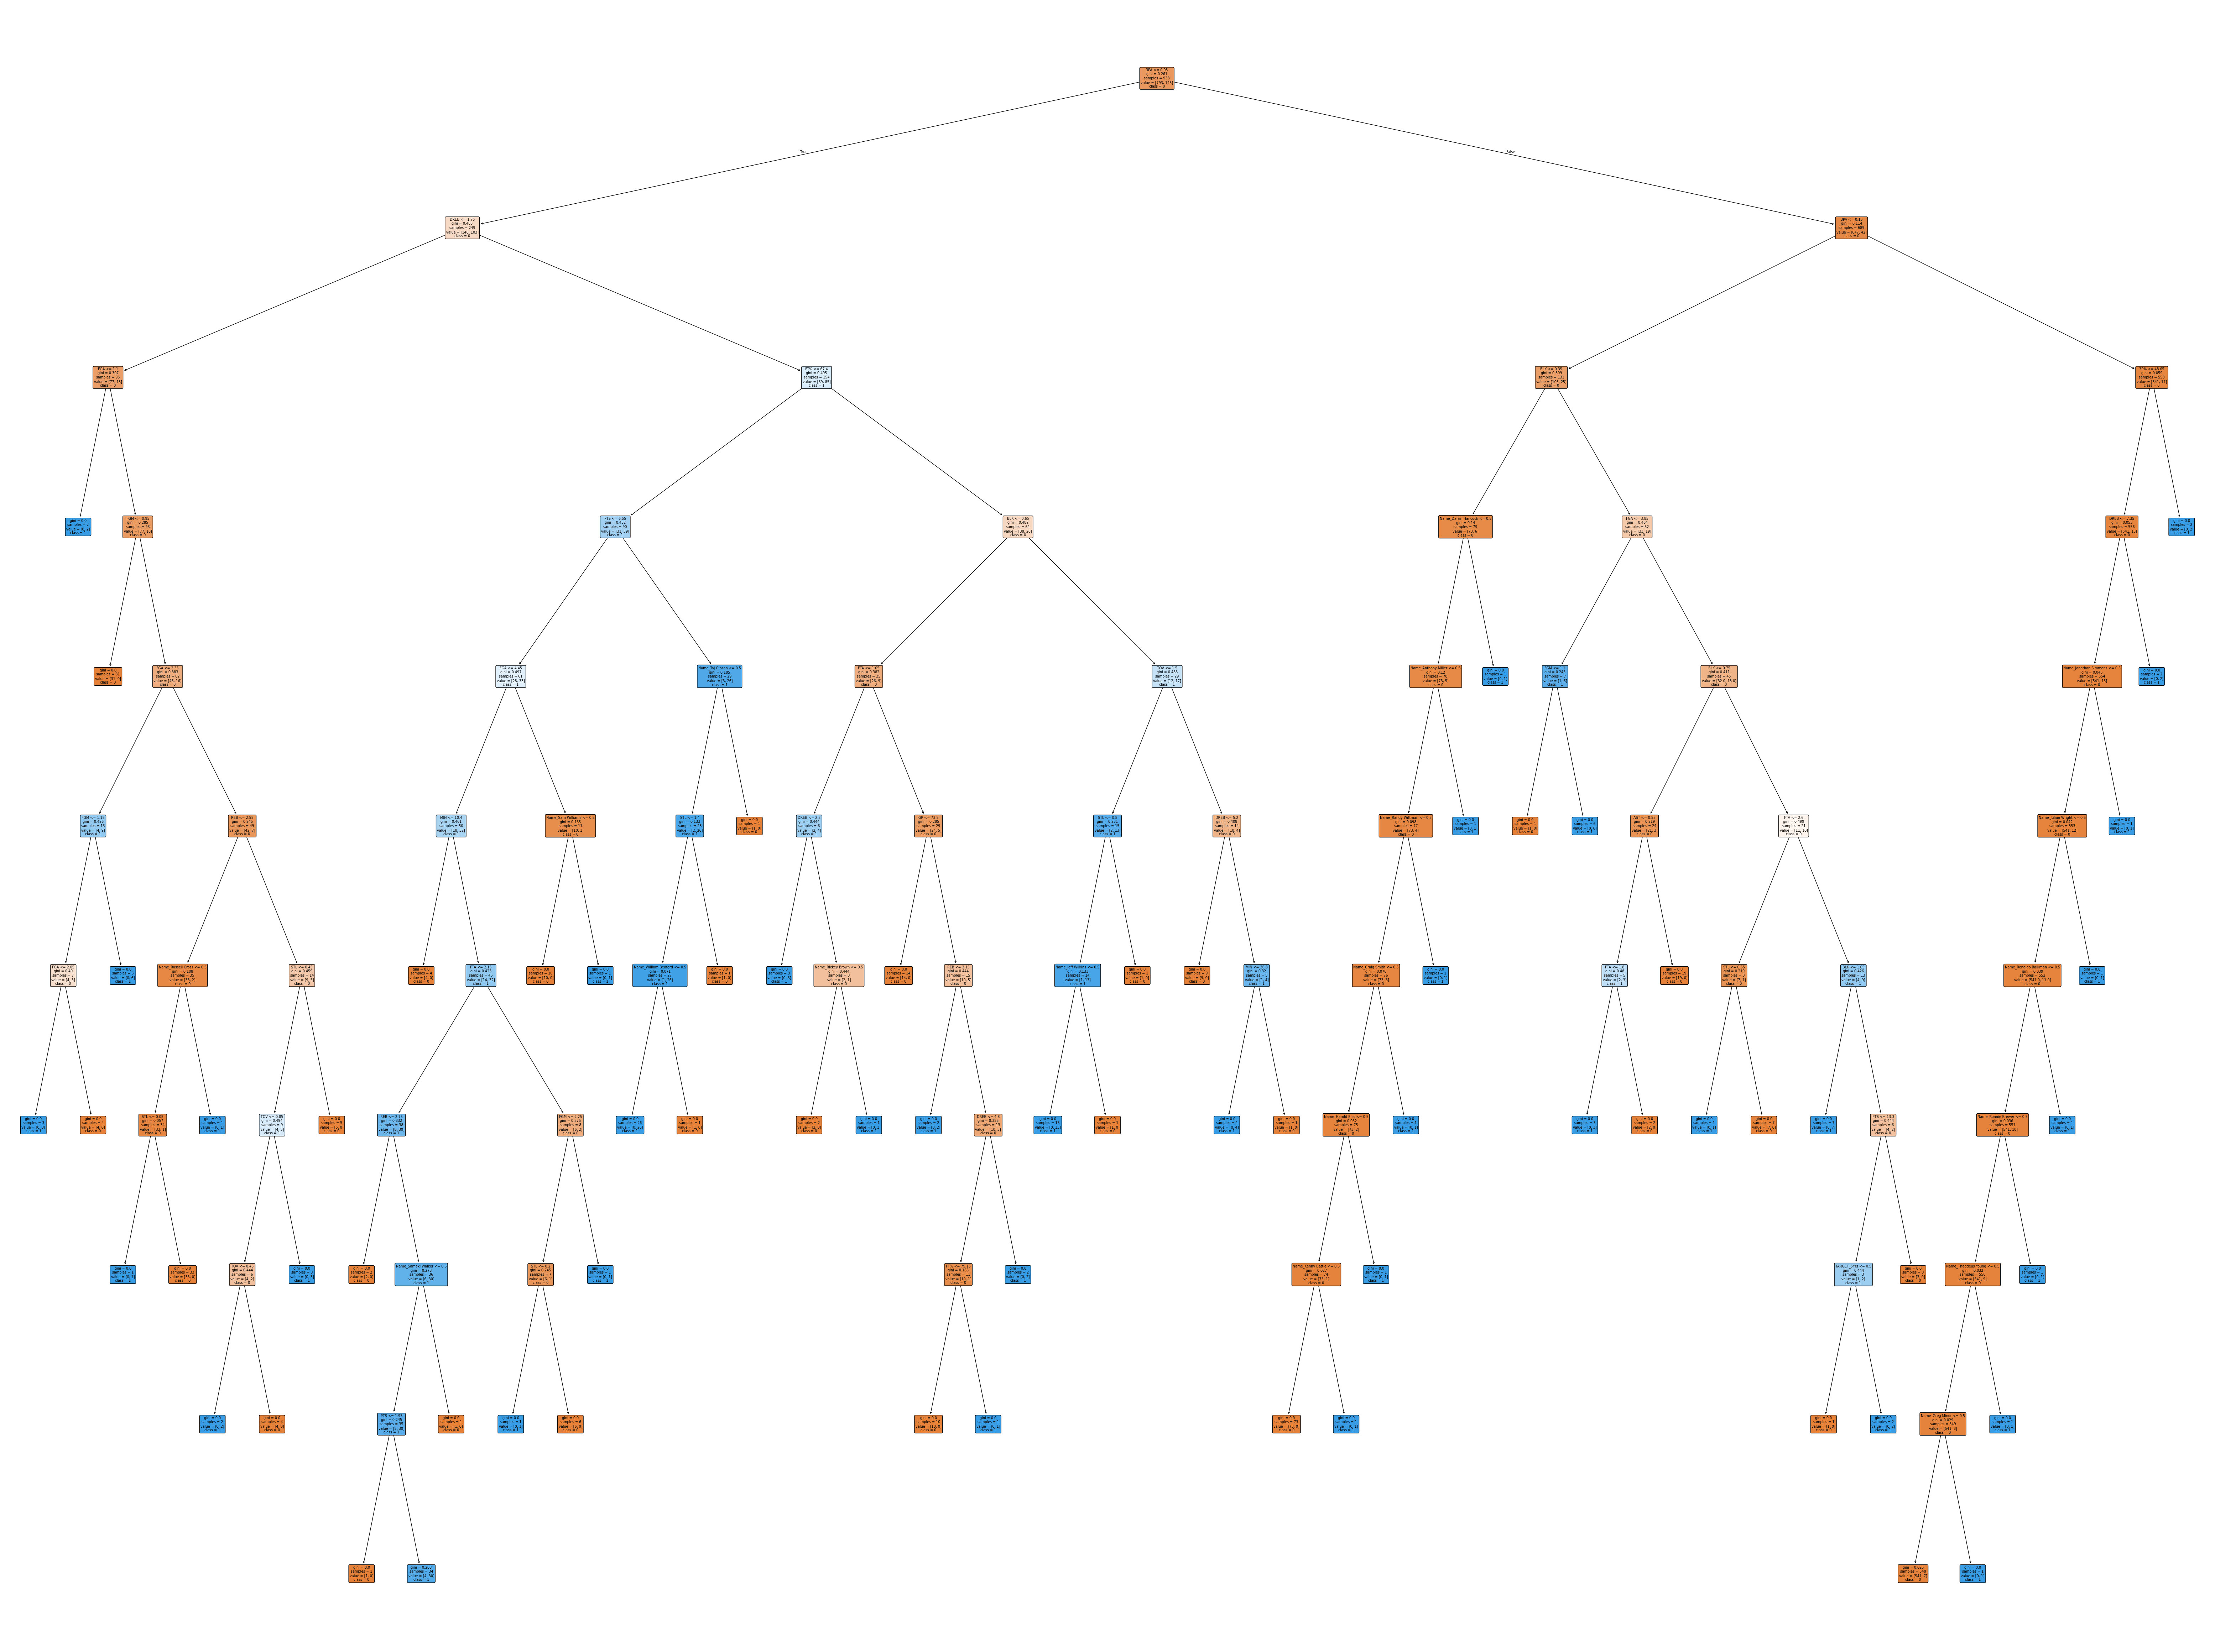

In [38]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()

# **OVERSAMPLING И построение дерева**

In [56]:
y_test_multi.value_counts()

,count
FG%,
0,335
1,67


In [57]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_test_multi, y_test_multi)

In [58]:
y_res.value_counts()

,count
FG%,
0,335
1,335


In [59]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_test_multi, y_test_multi)

In [60]:
print(y_res.value_counts())

FG%
0    335
1    335
Name: count, dtype: int64


In [61]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [62]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89       104
           1       0.83      0.99      0.91        97

    accuracy                           0.90       201
   macro avg       0.91      0.90      0.90       201
weighted avg       0.91      0.90      0.90       201



In [63]:
accuracy_score(y_test_multi, y_pred_multi)

0.900497512437811

In [65]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)

0.9034992069785884

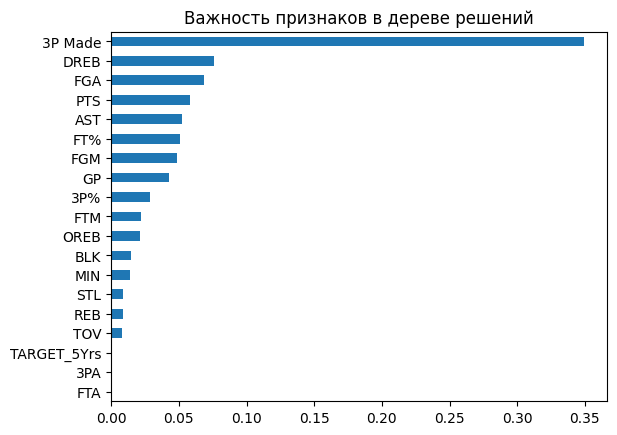

In [67]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X_res.columns)

columns_to_drop = feature_importances.index[feature_importances.index.str.startswith('Name_')]
feature_importances = feature_importances.drop(columns_to_drop)

feature_importances.sort_values().plot(kind='barh')

plt.title('Важность признаков в дереве решений')
plt.show()


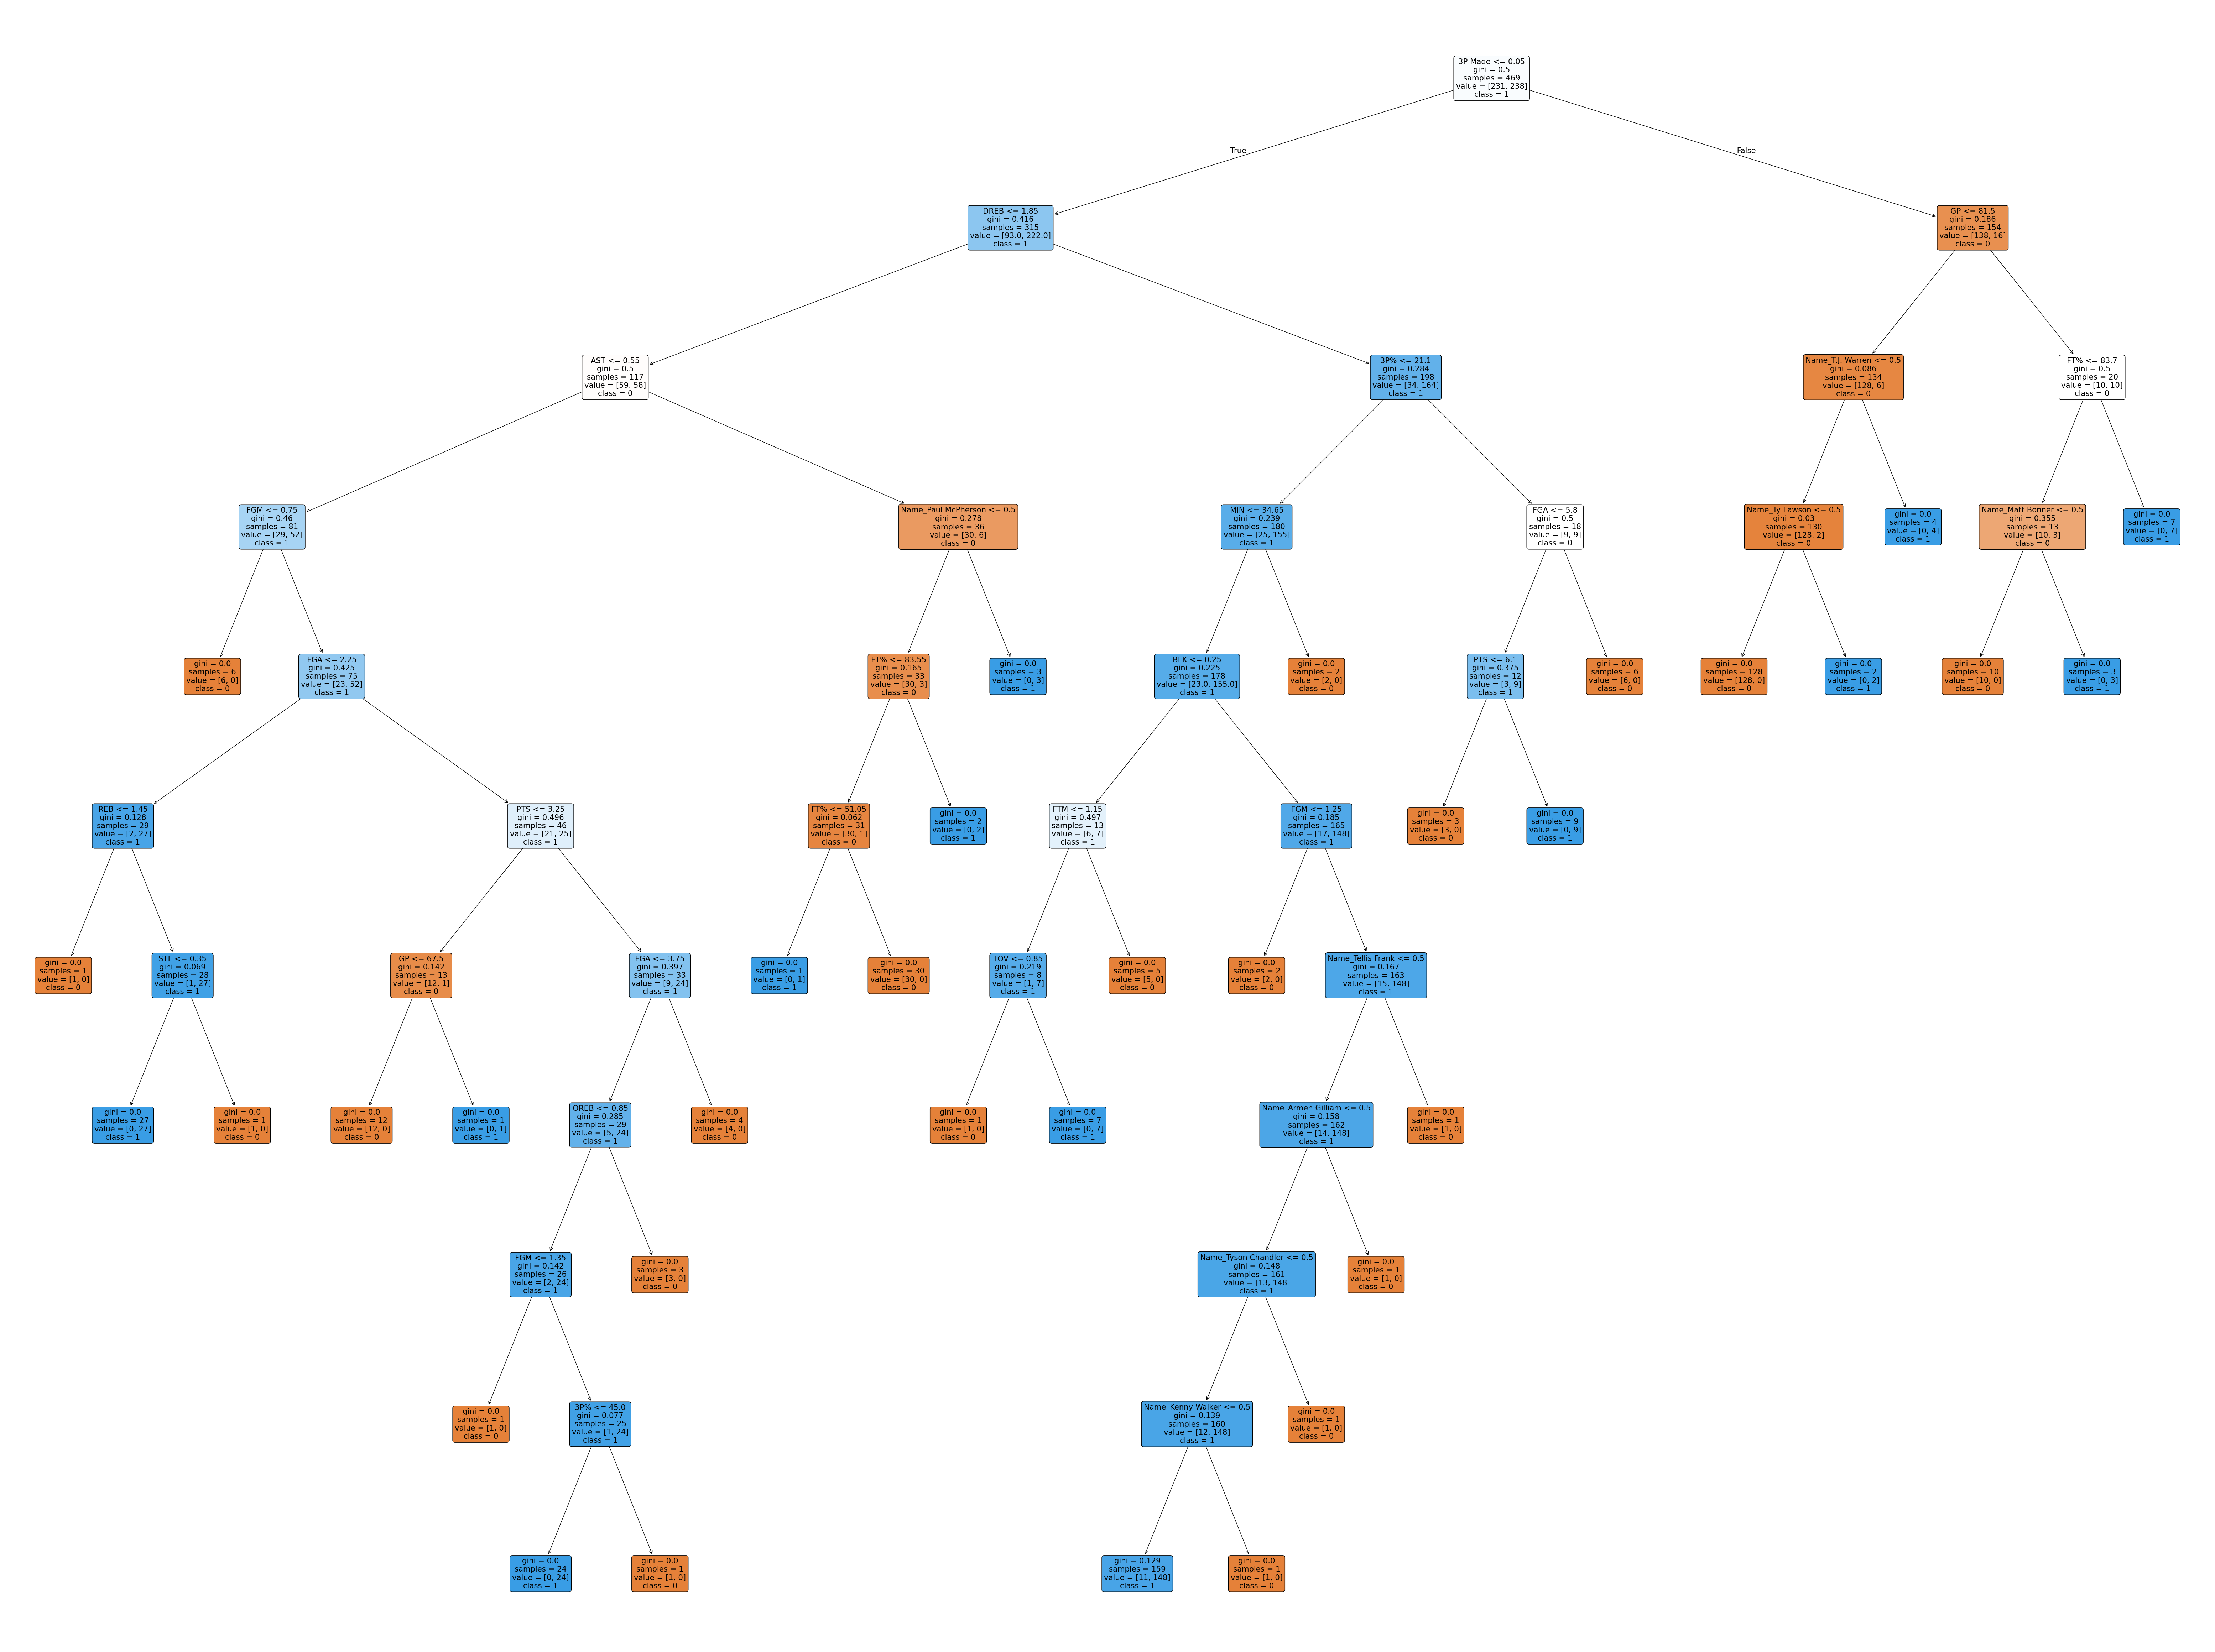

In [68]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X_res.columns, class_names=[str(item) for item in sorted(y_res.unique())], filled=True, rounded=True)
plt.show()